### Text Sentiment Analysis

#### This is version three

This script performs sentiment analysis on a dataset of airline tweets to classify them into three categories: negative, neutral, and positive. The analysis process consists of three main steps:

Preprocessing: The first script reads the raw airline tweets dataset, performs text preprocessing, such as removing special characters, stopwords, and converting to lowercase, and saves the preprocessed dataset to a .csv file.

Model Training and Evaluation: The second script reads the preprocessed dataset, splits it into training and testing sets, and trains three different machine learning models (Logistic Regression, Random Forest, and Support Vector Machine) using the TF-IDF representation of the text data. It performs hyperparameter tuning with GridSearchCV, evaluates the models using classification reports, and saves the model predictions to separate .csv files.

Visualization: The third script reads the predictions saved in .csv files, plots the confusion matrices for each model, and creates a side-by-side comparison of the confusion matrices for all three models to help visualize and compare their performance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copy the data to your local drive
!cp /content/drive/MyDrive/archive/archive-3/Tweets.csv /content/

In [36]:
import pandas as pd
from pandas import Series, DataFrame, isnull, notnull
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to clean the text
def clean_text(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert emoticons to words
    text = re.sub(r':\)', ' smile ', text)
    text = re.sub(r':\(', ' sad ', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    
    return text

# Load the Twitter data
data = pd.read_csv("Tweets.csv")

# Apply the clean_text function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Save preprocessed data to a new file
data.to_csv('preprocessed_tweets.csv', index=False)





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

data = pd.read_csv("preprocessed_tweets.csv")

X = data["cleaned_text"]
y = data["airline_sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train.astype('U'))
X_test_tfidf = vectorizer.transform(X_test.astype('U'))

models = [
    {
        "name": "LogisticRegression",
        "model": LogisticRegression(),
        "params": {"C": [0.1, 1, 10], "max_iter": [1000]},
    },
    {
        "name": "RandomForestClassifier",
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [10, 50, 100], "max_depth": [10, 20, None]},
    },
    {
        "name": "SVC",
        "model": SVC(),
        "params": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    },
]

for m in models:
    print(f"\n{m['name']} with best parameters:")
    clf = GridSearchCV(m["model"], m["params"], cv=5, n_jobs=-1)
    clf.fit(X_train_tfidf, y_train)
    best_params = clf.best_params_
    best_estimator = clf.best_estimator_
    print(best_params)

    y_pred = best_estimator.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

    # Save predictions to CSV files
    preds = pd.DataFrame({"true_label": y_test, "prediction": y_pred})
    preds.to_csv(f"{m['name']}_preds.csv", index=False)


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



LogisticRegression with best parameters:
{'C': 1, 'max_iter': 1000}
              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      1889
     neutral       0.70      0.48      0.57       580
    positive       0.79      0.60      0.68       459

    accuracy                           0.80      2928
   macro avg       0.77      0.67      0.71      2928
weighted avg       0.79      0.80      0.78      2928


RandomForestClassifier with best parameters:
{'max_depth': None, 'n_estimators': 100}
              precision    recall  f1-score   support

    negative       0.80      0.92      0.86      1889
     neutral       0.62      0.43      0.50       580
    positive       0.74      0.56      0.64       459

    accuracy                           0.77      2928
   macro avg       0.72      0.64      0.67      2928
weighted avg       0.75      0.77      0.75      2928


SVC with best parameters:
{'C': 1, 'kernel': 'linear'}
              precision   

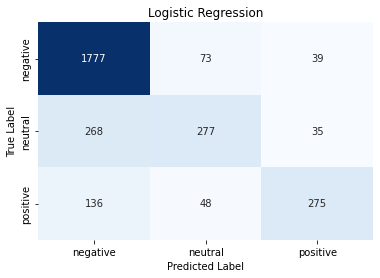

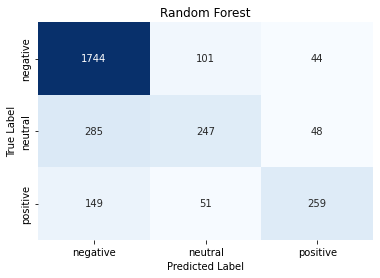

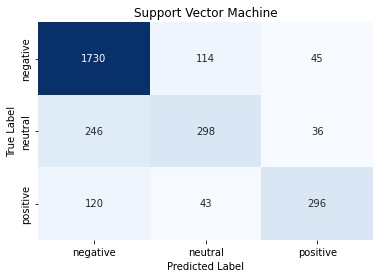

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load predictions and true labels
logreg_preds = pd.read_csv("LogisticRegression_preds.csv")
random_forest_preds = pd.read_csv("RandomForestClassifier_preds.csv")
svc_preds = pd.read_csv("SVC_preds.csv")

preds_data = [
    {"name": "Logistic Regression", "data": logreg_preds},
    {"name": "Random Forest", "data": random_forest_preds},
    {"name": "Support Vector Machine", "data": svc_preds},
]

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, title):
    matrix = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot confusion matrices for each model
for preds in preds_data:
    plot_confusion_matrix(preds["data"]["true_label"], preds["data"]["prediction"], preds["name"])

plt.show()
